In [1]:
from dummy_ads_data import campaigns, ad_groups, metrics

# summarize performance data by campaign
campaign_summary = {}
for campaign in campaigns:
    cid = campaign["id"]
    campaign_summary[cid] = {"name": campaign["name"], "total_clicks": 0, "total_cost": 0}

for metric in metrics:
    ag_id = metric["ad_group_id"]
    # ad_group -> campaign_id
    campaign_id = next(ag["campaign_id"] for ag in ad_groups if ag["id"] == ag_id)
    campaign_summary[campaign_id]["total_clicks"] += metric["clicks"]
    campaign_summary[campaign_id]["total_cost"] += metric["cost"]

# print summary
for cid, data in campaign_summary.items():
    print(f"Campaign '{data['name']}': Clicks={data['total_clicks']}, Cost=${data['total_cost']:.2f}")


Campaign 'App Install - IOS': Clicks=50511, Cost=$20935.56
Campaign 'App Install - Android': Clicks=49782, Cost=$19360.47
Campaign 'Retargeting Campaign': Clicks=25417, Cost=$10167.02


In [2]:
import pandas as pd

# convert to dataframe
df_summary = pd.DataFrame.from_dict(campaign_summary, orient="index")

df_summary

,name,total_clicks,total_cost
1,App Install - IOS,50511,20935.56
2,App Install - Android,49782,19360.47
3,Retargeting Campaign,25417,10167.02


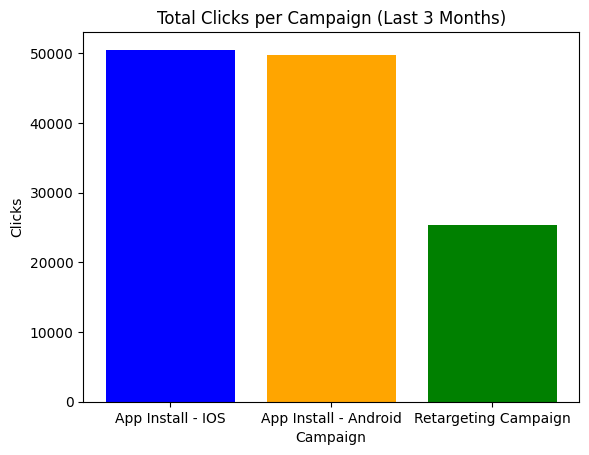

In [4]:
import matplotlib.pyplot as plt

plt.bar(df_summary["name"], df_summary["total_clicks"], color=["blue", "orange", "green"])
plt.title("Total Clicks per Campaign (Last 3 Months)")
plt.xlabel("Campaign")
plt.ylabel("Clicks")
plt.show()

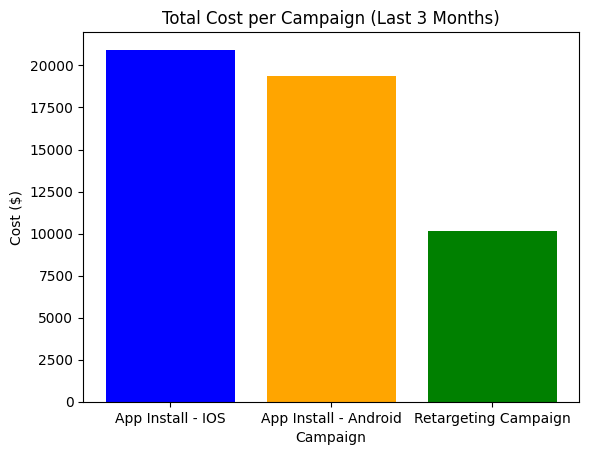

In [5]:
plt.bar(df_summary["name"], df_summary["total_cost"], color=["blue", "orange", "green"])
plt.title("Total Cost per Campaign (Last 3 Months)")
plt.xlabel("Campaign")
plt.ylabel("Cost ($)")
plt.show()

In [6]:
df_metrics = pd.DataFrame(metrics)

# join ad_group -> campaign
df_ad_groups = pd.DataFrame(ad_groups)
df_campaigns = pd.DataFrame(campaigns)

# merge ad_group into metrics
df = df_metrics.merge(df_ad_groups[["id", "campaign_id"]], left_on="ad_group_id", right_on="id")
df = df.merge(df_campaigns[["id", "name"]], left_on="campaign_id", right_on="id", suffixes=("_adgroup", "_campaign"))

# date column as datetime
df["date"] = pd.to_datetime(df["date"])
df.head()

,ad_group_id,date,impressions,clicks,cost,conversions,installs,revenue,id_adgroup,campaign_id,id_campaign,name
0,101,2025-01-01,1865,241,71.22,42,39,73.32,101,1,1,App Install - IOS
1,101,2025-01-02,4962,206,146.61,67,67,186.07,101,1,1,App Install - IOS
2,101,2025-01-03,1594,389,132.38,97,97,212.30,101,1,1,App Install - IOS
3,101,2025-01-04,722,329,178.86,51,51,127.02,101,1,1,App Install - IOS
4,101,2025-01-05,4580,483,68.74,21,22,64.65,101,1,1,App Install - IOS


In [7]:
df_daily = df.groupby(["date", "name"]).agg({
    "impressions": "sum",
    "clicks": "sum",
    "cost": "sum",
    "conversions": "sum",
    "installs": "sum",
    "revenue": "sum"
}).reset_index()
df_daily.head()

,date,name,impressions,clicks,cost,conversions,installs,revenue
0,2025-01-01,App Install - Android,3167,398,252.67,164,164,626.45
1,2025-01-01,App Install - IOS,3106,660,188.00,134,129,254.07
2,2025-01-01,Retargeting Campaign,3059,479,157.45,70,69,254.21
3,2025-01-02,App Install - Android,6835,628,165.34,144,144,588.57
4,2025-01-02,App Install - IOS,6055,307,187.78,138,139,479.41


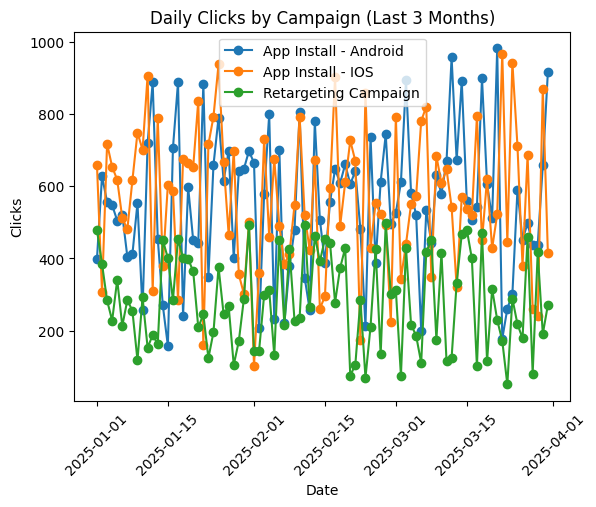

In [9]:
for campaign_name in df_daily["name"].unique():
    subset = df_daily[df_daily["name"] == campaign_name]
    plt.plot(subset["date"], subset["clicks"], marker="o", label=campaign_name)

plt.title("Daily Clicks by Campaign (Last 3 Months)")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Clicks")
plt.legend()
plt.show()

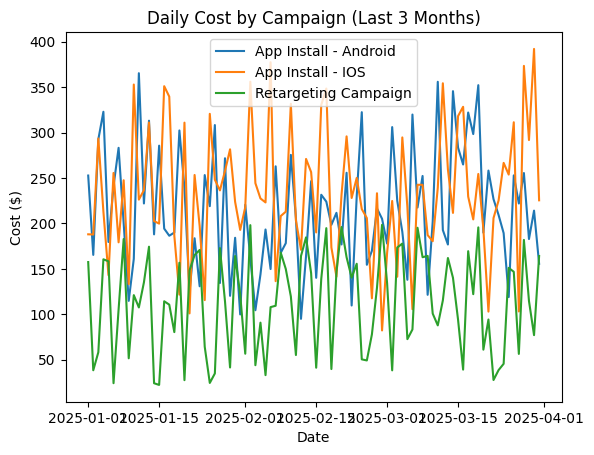

In [15]:
for campaign_name in df_daily["name"].unique():
    subset = df_daily[df_daily["name"] == campaign_name]
    plt.plot(subset["date"], subset["cost"], label=campaign_name)

plt.title("Daily Cost by Campaign (Last 3 Months)")
plt.xlabel("Date")
plt.ylabel("Cost ($)")
plt.legend()
plt.show()

#### Calculate KPIs
* CTR (Click-through Rate) = clicks / impressions
* CPC (Cost per Click) = cost / clicks
* CPA (Cost per Acquisition) = cost / conversions
* ROAS (Return on Ad Spend) = revenue / cost
* CR (Conversion Rate) = conversions / clicks

In [12]:
# calculate additional metrics
df_daily["CTR"] = df_daily["clicks"] / df_daily["impressions"].replace(0, pd.NA)
df_daily["CPC"] = df_daily["cost"] / df_daily["clicks"].replace(0, pd.NA)
df_daily["CPA"] = df_daily["cost"] / df_daily["conversions"].replace(0, pd.NA)
df_daily["ROAS"] = df_daily["revenue"] / df_daily["cost"].replace(0, pd.NA)
df_daily["CR"] = df_daily["conversions"] / df_daily["clicks"].replace(0, pd.NA)

df_daily.head()

,date,name,impressions,clicks,cost,conversions,installs,revenue,CTR,CPC,CPA,ROAS,CR
0,2025-01-01,App Install - Android,3167,398,252.67,164,164,626.45,0.125671,0.634849,1.540671,2.479321,0.412060
1,2025-01-01,App Install - IOS,3106,660,188.00,134,129,254.07,0.212492,0.284848,1.402985,1.351436,0.203030
2,2025-01-01,Retargeting Campaign,3059,479,157.45,70,69,254.21,0.156587,0.328706,2.249286,1.614544,0.146138
3,2025-01-02,App Install - Android,6835,628,165.34,144,144,588.57,0.091880,0.263280,1.148194,3.559756,0.229299
4,2025-01-02,App Install - IOS,6055,307,187.78,138,139,479.41,0.050702,0.611661,1.360725,2.553041,0.449511


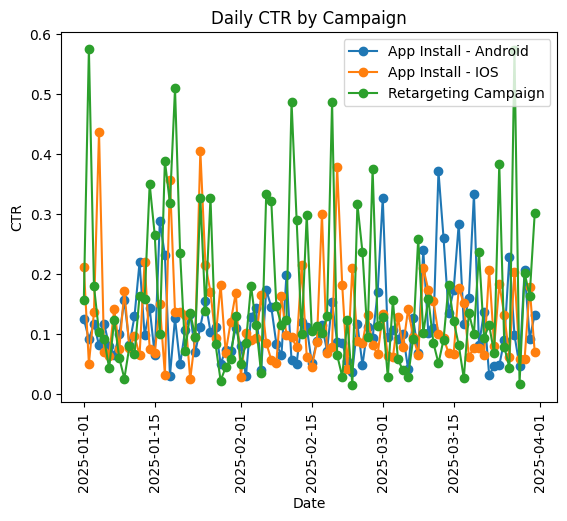

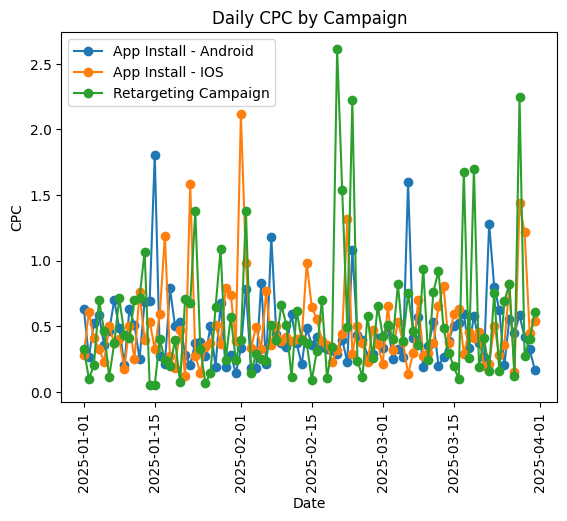

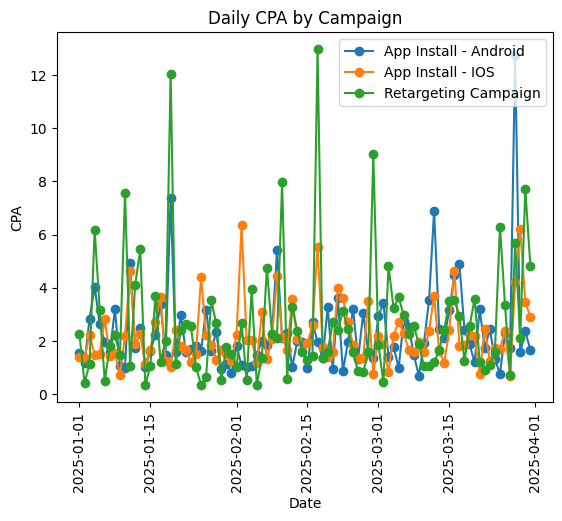

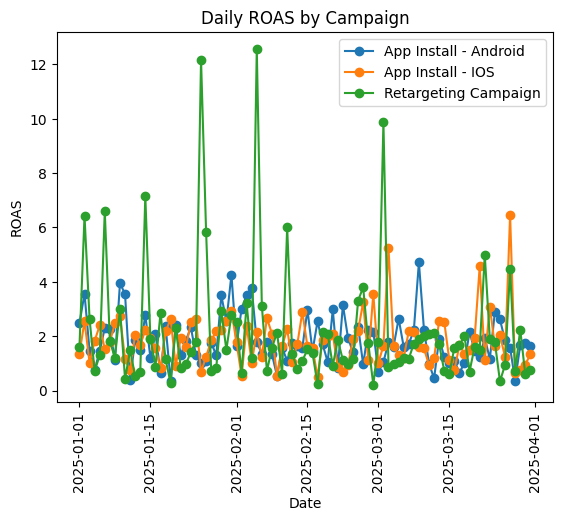

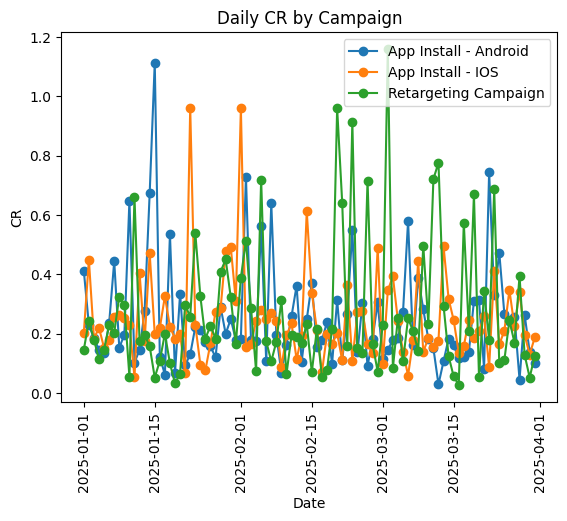

In [13]:
# plot KPIs
kpis = ["CTR", "CPC", "CPA", "ROAS", "CR"]

for kpi in kpis:
    for campaign_name in df_daily["name"].unique():
        subset = df_daily[df_daily["name"] == campaign_name]
        plt.plot(subset["date"], subset[kpi], marker="o", label=campaign_name)

    plt.title(f"Daily {kpi} by Campaign")
    plt.xlabel("Date")
    plt.xticks(rotation=90)
    plt.ylabel(kpi)
    plt.legend()
    plt.show()

<Axes: >

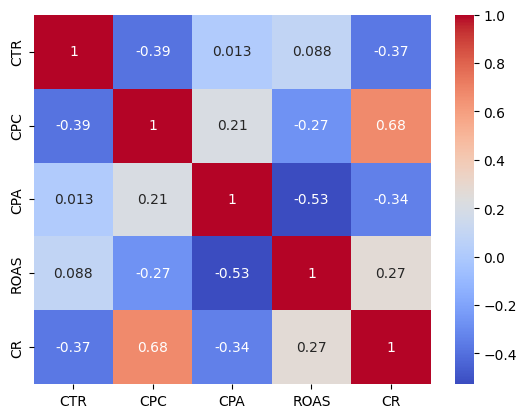

In [16]:
import seaborn as sns

corr = df_daily[["CTR", "CPC", "CPA", "ROAS", "CR"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")

Trend Analysis (Moving Average)
* Rolling Window : 7 days

In [ ]:
df_daily['CTR_7d_avg'] = df_daily['CTR'].rolling(window=7).mean()
df['CPC_7d_avg'] = df['CPC'].rolling(window=7).mean()
df['CPA_7d_avg'] = df['CPA'].rolling(window=7).mean()
df['ROAS_7d_avg'] = df['ROAS'].rolling(window=7).mean()
df['CR_7d_avg'] = df['CR'].rolling(window=7).mean()


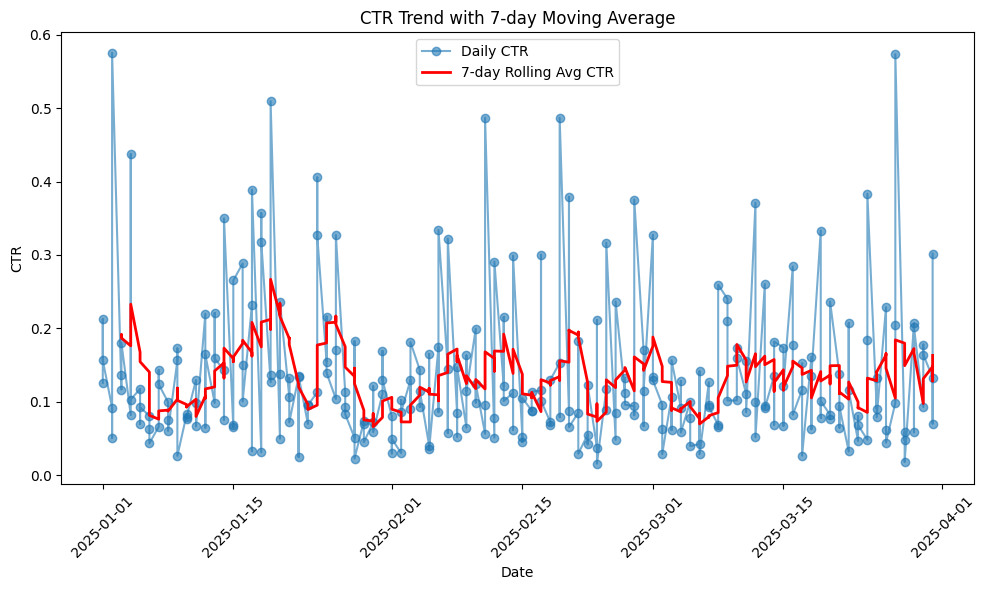

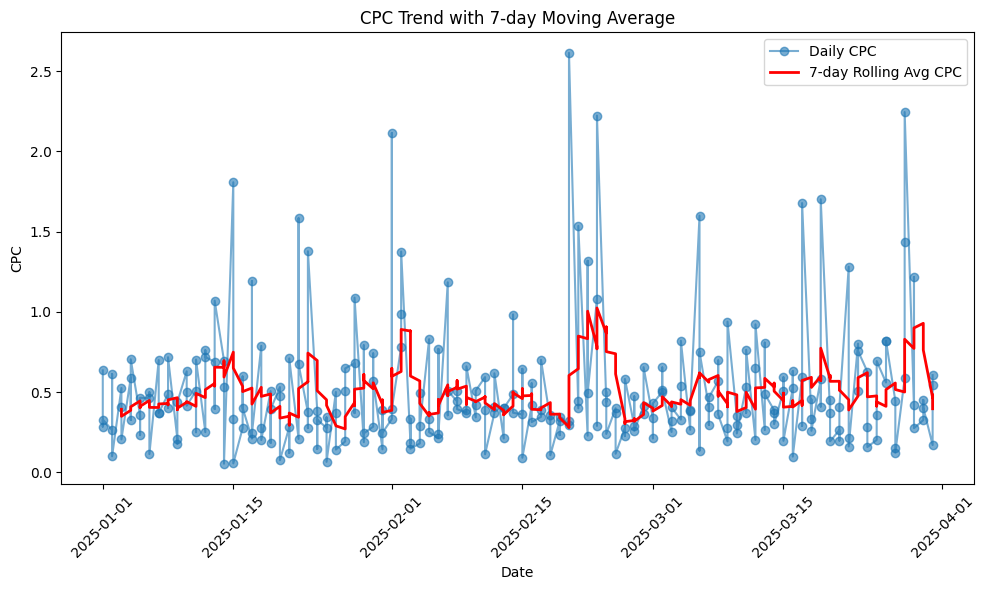

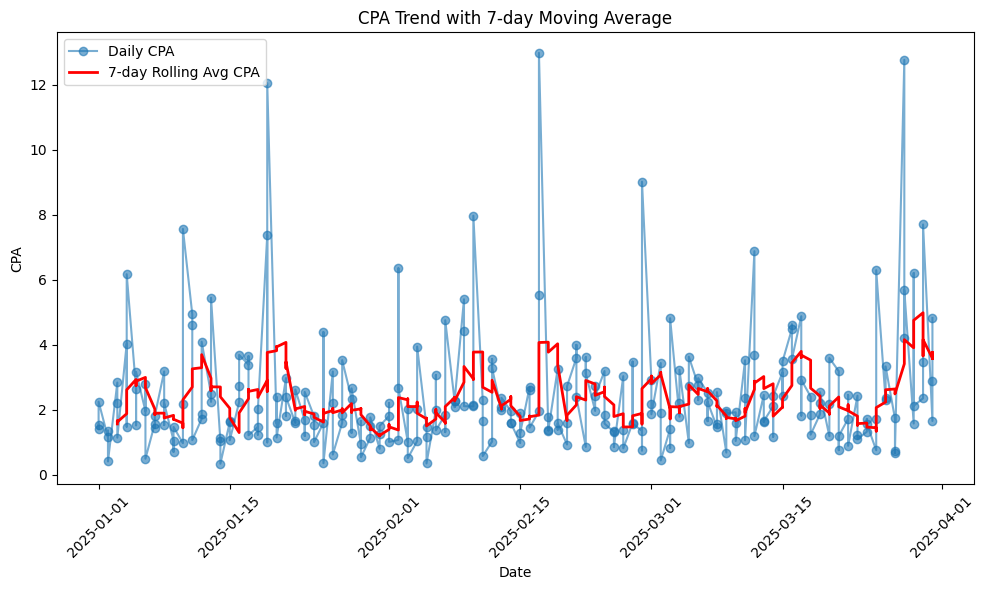

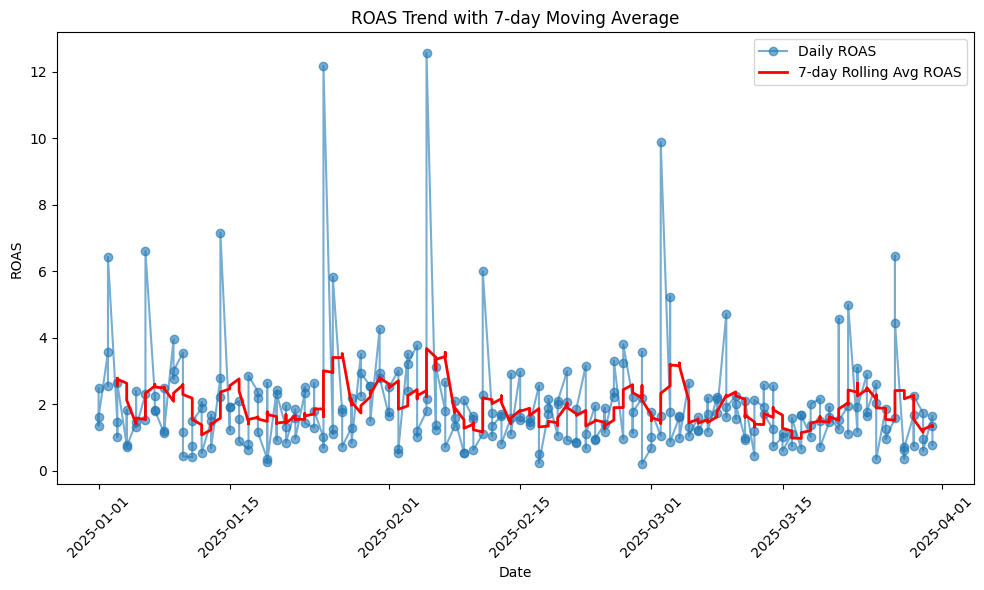

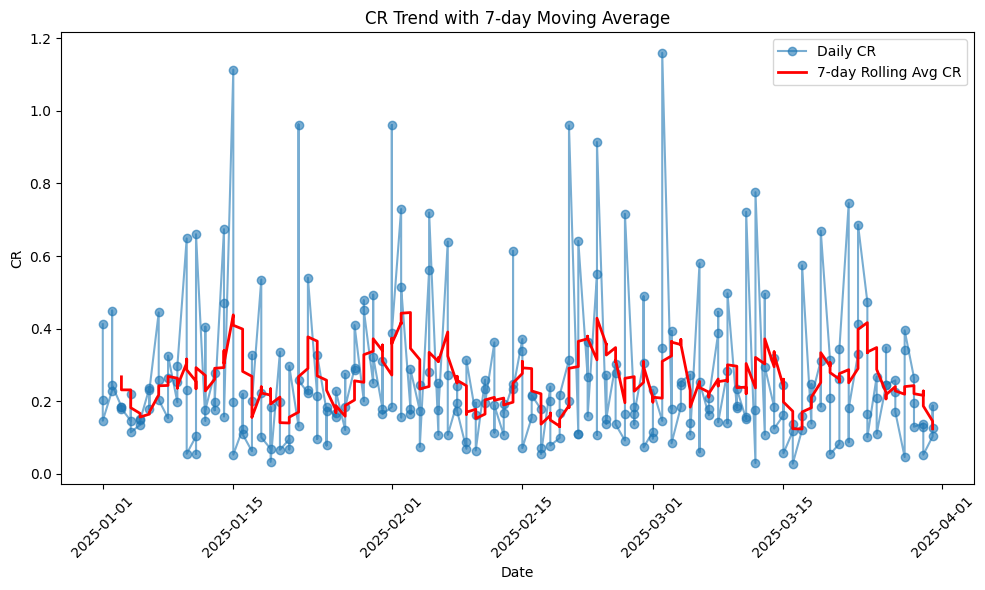

In [ ]:
# Plot trends with moving averages
for kpi in kpis:
    df_daily[f"{kpi}_7d_avg"] = df_daily[kpi].rolling(window=7).mean()
    plt.figure(figsize=(10,6))
    plt.plot(df_daily['date'], df_daily[kpi], label=f"Daily {kpi}", marker="o", alpha=0.6)
    plt.plot(df_daily['date'], df_daily[f"{kpi}_7d_avg"], label=f"7-day Rolling Avg {kpi}", linewidth=2, color="red")
    plt.title(f"{kpi} Trend with 7-day Moving Average")
    plt.xlabel("Date")
    plt.ylabel(kpi)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Anomaly Detection using Rolling Statistics

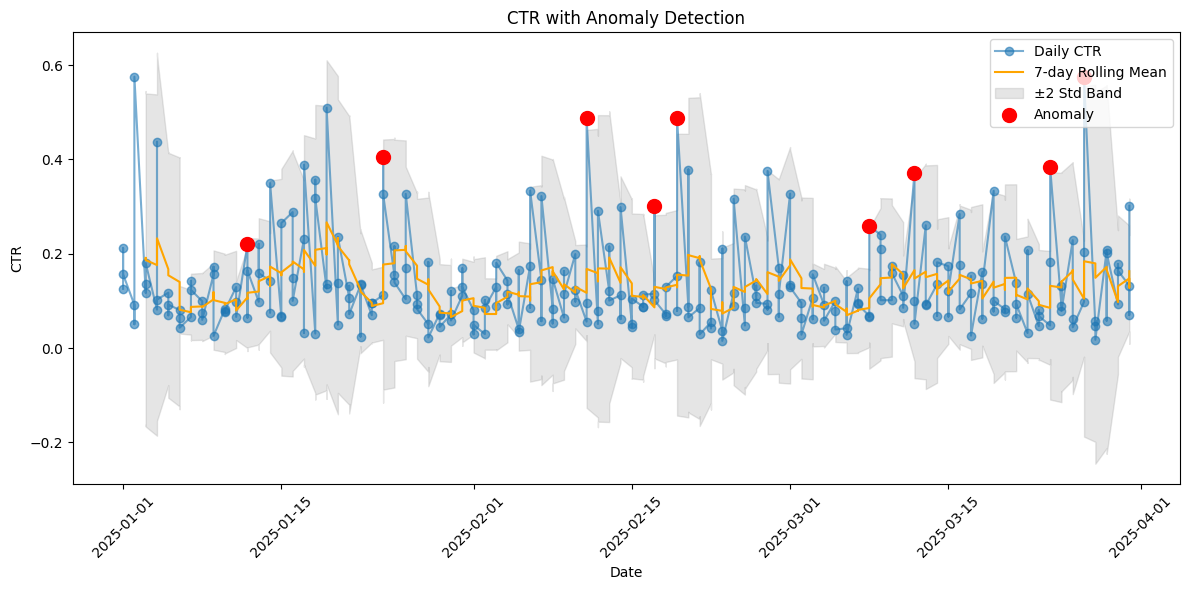

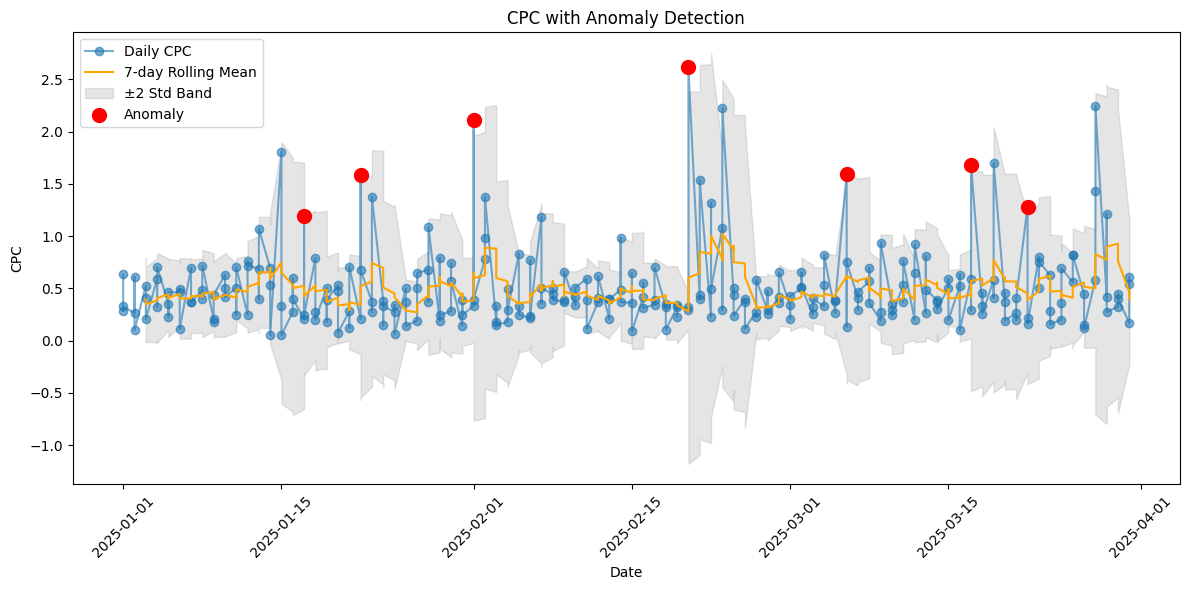

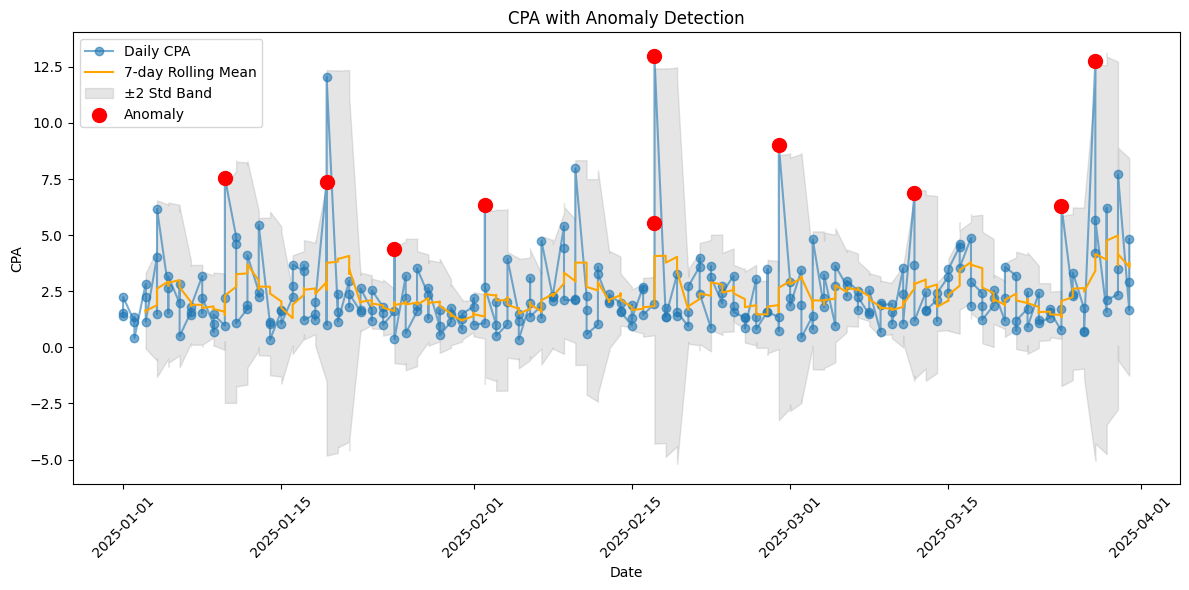

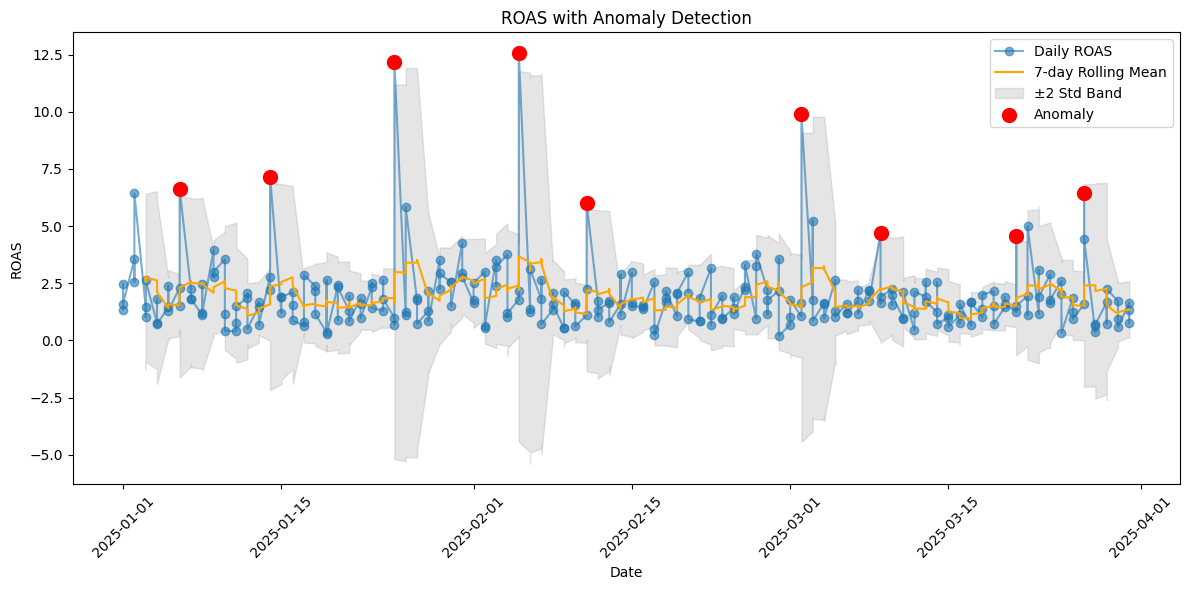

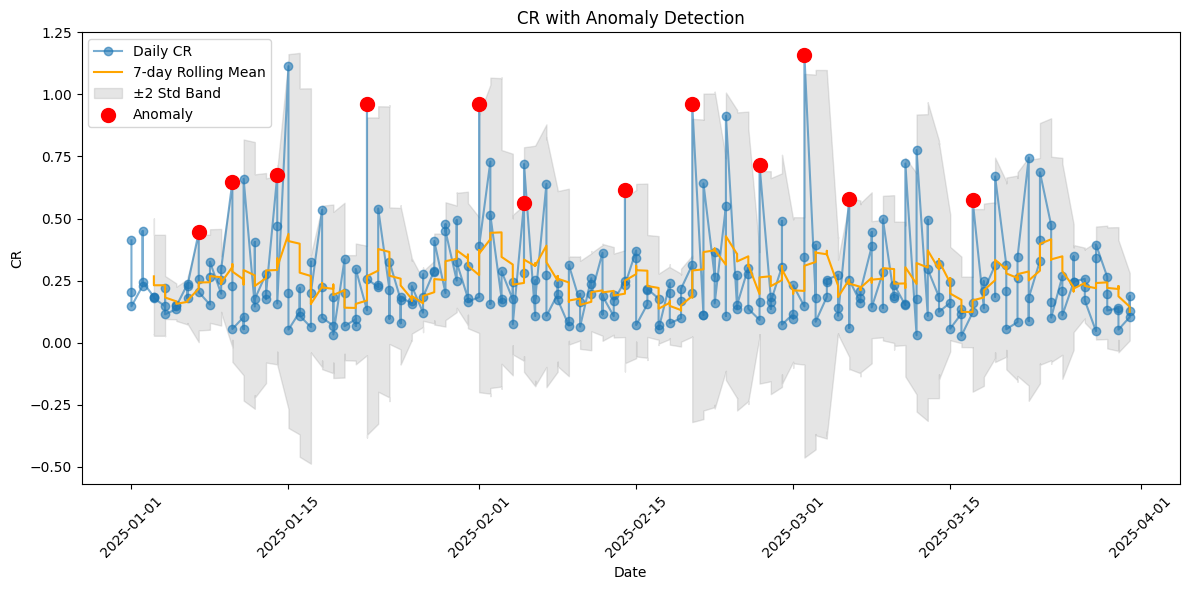

In [26]:

for kpi in kpis:
    # Rolling mean and std
    df_daily[f"{kpi}_7d_std"] = df_daily[kpi].rolling(window=7).std()

    # Upper and lower bounds
    df_daily[f"{kpi}_upper"] = df_daily[f"{kpi}_7d_avg"] + 2*df_daily[f"{kpi}_7d_std"]
    df_daily[f"{kpi}_lower"] = df_daily[f"{kpi}_7d_avg"] - 2*df_daily[f"{kpi}_7d_std"]

    # Anomaly detection flag
    df_daily[f"{kpi}_anomaly"] = (df_daily[kpi] > df_daily[f"{kpi}_upper"]) | (df_daily[kpi] < df_daily[f"{kpi}_lower"])

    # Plot
    plt.figure(figsize=(12,6))
    plt.plot(df_daily["date"], df_daily[kpi], label=f"Daily {kpi}", marker="o", alpha=0.6)
    plt.plot(df_daily["date"], df_daily[f"{kpi}_7d_avg"], label="7-day Rolling Mean", color="orange")
    plt.fill_between(df_daily["date"], df_daily[f"{kpi}_lower"], df_daily[f"{kpi}_upper"], color="gray", alpha=0.2, label="±2 Std Band")

    # Mark anomalies
    anomalies = df_daily[df_daily[f"{kpi}_anomaly"]]
    plt.scatter(anomalies["date"], anomalies[kpi], color="red", label="Anomaly", s=100, zorder=5)

    plt.title(f"{kpi} with Anomaly Detection")
    plt.xlabel("Date")
    plt.ylabel(kpi)
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()